### Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import math
import numpy as np
import  wandb
import os
import time

from torchmetrics import Dice
import segmentation_models_pytorch as smp

## depend to the files of the project
import utils 
from utils import load, save, plot
from benchmark import dataset
from Unet import unet
from utils import load, save, plot

### Loading the WandB

In [ ]:
key_file = './wandb-key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

### Arguments

In [25]:
seed = 3
wandb_enable = True

info = {'num_epoch' :10,
        'lr' : 0.3,
        'weight_decay' : 1e-05,
        'device' : 'cuda',
        'reset': True,
        'name_load' : 'name',
        'model_load_path' : './model/',
        'model_save_path' : './model/'
        }



Initialize `wandb`

In [7]:
wandb_arg_name = 'unet' # name of this training process
wandb.init(
        project='Medical Image Segmentation',  # name of the project
        name=wandb_arg_name,
        config={
            'lr': info['lr'],
            'weight_decay': info['weight_decay'],
            'num_epoch': info['num_epoch']
        }
    )


### Main Loop

In [26]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

Deffine the `Dataloader`

In [22]:
train_batch_size = 32
valid_batch_size = 64

train_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='train', mini=False, memory=True)(batch_size=train_batch_size)
valid_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='valid', mini=False, memory=False)(batch_size=valid_batch_size)

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


 Define the `Model` - `Optimizer` - `Loss Function` - `Metric`

In [27]:
load_path = info['model_load_path'] + info['name_load'] + ".pth"

model = unet.UNet(n_channels=3, n_classes=3, bilinear=False).to(info['device'])

optimizer = optim.SGD(model.parameters(), lr=info['lr'], weight_decay=info['weight_decay'], momentum=0.9)# , nesterov=True
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)

loss_fn = smp.losses.DiceLoss(mode='multilabel')

metric = Dice().to(info['device'])

model, loss_fn, _ = load(model, loss_fn, optimizer, device=info['device'], reset = info['reset'], load_path = load_path)

save_path = info['model_save_path'] + 'unet'+ ".pth"

**`Training`**

In [30]:
epochs = info['num_epoch']

for epoch in range(1, epochs+1):
    ## Train
    model, loss_train, metric_train = utils.train_one_epoch(model,
                                                            train_loader,
                                                            loss_fn,
                                                            optimizer,
                                                            metric,
                                                            epoch,
                                                            device=info['device'])
    
    ## Validation
    loss_valid, metric_valid = utils.evaluate(model,
                                              valid_loader,
                                              loss_fn,
                                              metric,
                                              device=info['device'])

        
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)


    print(f'Train      - Loss:{loss_train}  Metric:{metric_train}')
    print(f'Validation - Loss:{loss_valid}  Metric:{metric_valid}')
    print(f'LR = {lr_scheduler.get_last_lr()[0]}')
    print()

    if loss_valid < best_loss_valid:
        save(save_path, model, optimizer, loss_fn)
        best_loss_valid = loss_valid
        print('Model Saved ("o")')

    if wandb_enable:
        wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                   "metric_valid": metric_valid, "loss_valid": loss_valid})
        
    lr_scheduler.step()

    epoch_counter += 1





  0%|          | 0/376 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 376/376 [08:42<00:00,  1.39s/batch, loss=0.143, metric=0.85] 


Train      - Loss:0.14312610030174255  Metric:0.8500948548316956
Validation - Loss:0.2031872272491455  Metric:0.7894536256790161
LR = 0.003



Epoch 2: 100%|██████████| 376/376 [08:43<00:00,  1.39s/batch, loss=0.143, metric=0.85] 


Train      - Loss:0.14325527846813202  Metric:0.8498080968856812
Validation - Loss:0.19924020767211914  Metric:0.792933464050293
LR = 0.003



Epoch 3: 100%|██████████| 376/376 [08:50<00:00,  1.41s/batch, loss=0.143, metric=0.85] 


Train      - Loss:0.14320361614227295  Metric:0.8501619696617126
Validation - Loss:0.19969667494297028  Metric:0.7921416163444519
LR = 0.003



Epoch 4: 100%|██████████| 376/376 [08:46<00:00,  1.40s/batch, loss=0.143, metric=0.851]


Train      - Loss:0.14275358617305756  Metric:0.8507795929908752
Validation - Loss:0.20075640082359314  Metric:0.7910115122795105
LR = 0.003



Epoch 5: 100%|██████████| 376/376 [08:46<00:00,  1.40s/batch, loss=0.143, metric=0.851]


Train      - Loss:0.14267568290233612  Metric:0.8508689403533936
Validation - Loss:0.20128613710403442  Metric:0.7892723679542542
LR = 0.003



Epoch 6: 100%|██████████| 376/376 [09:00<00:00,  1.44s/batch, loss=0.143, metric=0.851]


Train      - Loss:0.1426991969347  Metric:0.8507552146911621
Validation - Loss:0.19833073019981384  Metric:0.7930324673652649
LR = 0.00030000000000000003

Model Saved ("o")


Epoch 7: 100%|██████████| 376/376 [11:00<00:00,  1.76s/batch, loss=0.142, metric=0.851]


Train      - Loss:0.14227168262004852  Metric:0.8511493802070618
Validation - Loss:0.20154008269309998  Metric:0.7902300953865051
LR = 0.00030000000000000003



Epoch 8: 100%|██████████| 376/376 [11:50<00:00,  1.89s/batch, loss=0.143, metric=0.851]


Train      - Loss:0.14257557690143585  Metric:0.8509413003921509
Validation - Loss:0.20205406844615936  Metric:0.7901759147644043
LR = 0.00030000000000000003



Epoch 9: 100%|██████████| 376/376 [11:52<00:00,  1.89s/batch, loss=0.142, metric=0.851]


Train      - Loss:0.1423845738172531  Metric:0.8511108756065369
Validation - Loss:0.20002682507038116  Metric:0.7920966148376465
LR = 0.00030000000000000003



Epoch 10: 100%|██████████| 376/376 [10:51<00:00,  1.73s/batch, loss=0.142, metric=0.851]


Train      - Loss:0.1419021040201187  Metric:0.8513803482055664
Validation - Loss:0.198538675904274  Metric:0.7921291589736938
LR = 0.00030000000000000003



In [ ]:
wandb.finish()

### Plot learning curves


Trained 10 epochs


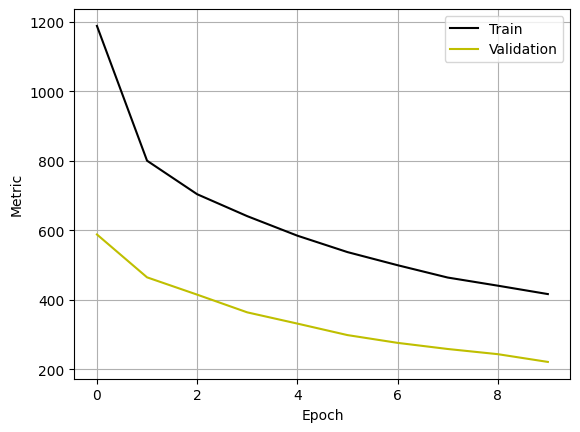


Trained 10 epochs


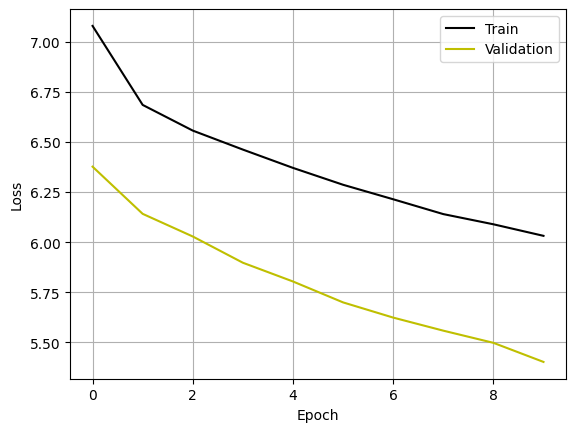

In [10]:
plot(metric_train_hist, metric_valid_hist, "Metric")
plot(loss_train_hist, loss_valid_hist, 'Loss')